In [1]:
import os, getpass
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain.tools.retriever import create_retriever_tool
from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model
from langgraph.graph import MessagesState
from typing import Literal
import gradio as gr

In [2]:
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

In [3]:
embedding = OpenAIEmbeddings()

In [4]:
vectorstore = Chroma(persist_directory=f"../db/rag_db", embedding_function=embedding)

In [5]:
retriever = vectorstore.as_retriever()

In [6]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

In [7]:
retriever_tool.invoke({"query": "Who is Alex Chen"})

'## Other HR Notes\n- Participates regularly in Insurellm\'s Diversity & Inclusion initiatives, championing tech accessibility for underrepresented communities.\n- Completed several certifications in cloud architecture and DevOps, contributing to professional growth.\n- Plans for a professional development course in AI and machine learning to further enhance backend capabilities in Insurellm\'s offerings.\n- Acknowledged for volunteer efforts in local tech meetups, bringing seasoned engineers to mentor aspiring coders.  \n\nAlex Chen continues to be a vital asset at Insurellm, contributing significantly to innovative backend solutions that help shape the future of insurance technology.\n\n# HR Record\n\n# Alex Chen\n\n## Summary\n- **Date of Birth:** March 15, 1990  \n- **Job Title:** Backend Software Engineer  \n- **Location:** San Francisco, California  \n\n## Insurellm Career Progression\n- **April 2020:** Joined Insurellm as a Junior Backend Developer. Focused on building APIs to e

In [8]:
grade_prompt = (
    "Use the information below to answer the user's question. "
    "If you can't find a suitable answer, just say you don't know. "
    "Don't give wrong or incorrect answers. "
    "{context} "
    "Câu hỏi: {question} "
)

In [9]:
class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )

In [10]:
grader_model = init_chat_model("openai:gpt-4o-mini", temperature=0)

In [11]:
def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        grader_model
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

In [12]:
def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = grade_prompt.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [13]:
from langchain_core.messages import convert_to_messages

In [14]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [15]:
rewrite_prompt = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)

In [16]:
def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = rewrite_prompt.format(question=question)
    response = grader_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [17]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = grader_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [18]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


In [19]:
workflow = StateGraph(MessagesState)

In [20]:
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")
graph = workflow.compile(name="rag_lang_graph")

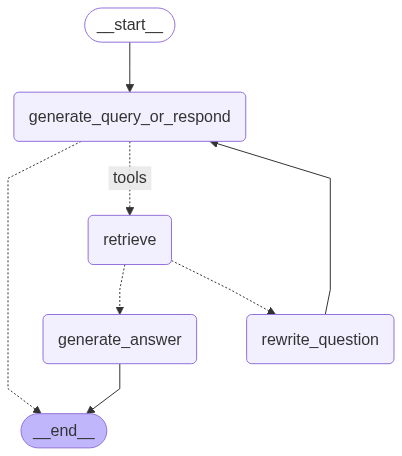

In [39]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
# for chunk in graph.stream(
#     {
#         "messages": [
#             {
#                 "role": "user",
#                 "content": "Who is Alex Chen?",
#             }
#         ]
#     }
# ):
#     for node, update in chunk.items():
#         # update["messages"][-1].pretty_print()
#         print(update["messages"][-1].content)

In [23]:
# def chat(question, history):
#     msg = {"role": "user", "content": ""}
#     for chunk in graph.stream(
#     {
#         "messages": [
#             {
#                 "role": "user",
#                 "content": question,
#             }
#         ]
#     }):
#         for node, update in chunk.items():
#             update["messages"][-1].pretty_print()
#             msg["content"] = update["messages"][-1].content
#     return msg
#
# view = gr.ChatInterface(chat, type="messages").launch()

In [40]:
response = graph.invoke({
        "messages": [
            {
                "role": "user",
                "content": "Who is Alex Chen?",
            }
        ]
    })
response["messages"][-1].content

'Alex Chen is a Senior Backend Software Engineer at Insurellm, recognized for his contributions to innovative backend solutions in insurance technology. He has progressed from a Junior Backend Developer to his current role since joining the company in April 2020. Alex is also involved in diversity and inclusion initiatives and has plans for further professional development in AI and machine learning.'

In [43]:
from typing import Annotated
from langgraph.prebuilt import InjectedState
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.types import Command
def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            goto=agent_name,
            update={**state, "messages": state["messages"] + [tool_message]},
            graph=Command.PARENT,
        )

    return handoff_tool

In [49]:
assign_to_rag_agent = create_handoff_tool(
    agent_name="rag_lang_graph",
    description="Assign task to a rag agent.",
)

In [51]:
from langgraph.prebuilt import create_react_agent
supervisor_agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[assign_to_rag_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a rag agent. Assign rag tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)


In [53]:
supervisor = (
    StateGraph(MessagesState)
    # NOTE: `destinations` is only needed for visualization and doesn't affect runtime behavior
    .add_node(supervisor_agent, destinations=("rag_lang_graph", END))
    .add_node(graph)
    .add_edge(START, "supervisor")
    # always return back to the supervisor
    .add_edge("rag_lang_graph", "supervisor")
    .compile()
)

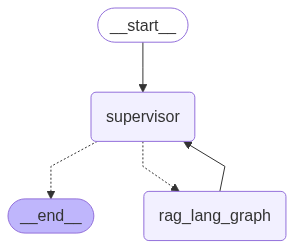

In [54]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [56]:
def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)

def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [57]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Who is Alex Chen?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_rag_lang_graph

Successfully transferred to rag_lang_graph


Update from node rag_lang_graph:


================================== Ai Message ==================================

Alex Chen is a Senior Backend Software Engineer at Insurellm, where he has significantly contributed to innovative backend solutions and the development of a microservices architecture. He joined the company in April 2020 as a Junior Backend Developer and was promoted due to his exemplary performance. Additionally, he is involved in diversity and inclusion initiatives and plans to enhance his skills in AI and machine learning.


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

Alex Chen is a Senior Backend Software Engineer at Insurellm, based in San Francisco, California. He was born on March 15, 1990, 